In [118]:
# Import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

# Random seed for reproducibility
seed = 202
np.random.seed(seed)

In [119]:
# Import the train set and test set
train_data = pd.read_csv("train_rodolfo.csv", delimiter=",")
test_data = pd.read_csv("test_rodolfo.csv", delimiter=",")

In [120]:
#train_data = train_data.drop('DataArpu', axis=1)
train_data = train_data.drop('ID', axis=1)
# Sort the dataset
train_data = train_data.iloc[np.random.permutation(len(train_data))]
train_data = train_data[['DeviceFlag4G', 'DataArpu', 'DataAllowanceContinuous',
       'DeviceFlagSmartphone', 'MonthlyVoiceTrafficCount',
       'MonthlySMSTrafficCount', 'MonthlyDataTraffic', 'CustomerGender',
       'CustomerExpatriate', 'ChurnScore', 'AirportConnectionsDuration',
       'AirportConnectionsCount', 'StationConnectionsDuration',
       'StationConnectionsCount', 'ParkingConnectionsDuration',
       'ParkingConnectionsCount', 'File-Transfer', 'Games',
       'Instant-Messaging-Applications', 'Mail', 'Music-Streaming',
       'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications', 'IsModified', 'CustomerAge', 'Region', 'Province',
       'Product']]
train_data = train_data.reset_index(drop=True)

In [121]:
array = np.asarray(train_data)

X = array[:,0:train_data.shape[1]-1]
X = np.asarray(X)
Y = array[:,train_data.shape[1]-1]
Y = np.asarray(Y)

In [122]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
chi2_test = SelectKBest(score_func=chi2, k=29)
fit = chi2_test.fit(X,Y)

In [123]:
train_data.columns[chi2_test.get_support(indices=True)]

Index(['DeviceFlag4G', 'DataArpu', 'DataAllowanceContinuous',
       'DeviceFlagSmartphone', 'MonthlyVoiceTrafficCount',
       'MonthlyDataTraffic', 'CustomerGender', 'CustomerExpatriate',
       'ChurnScore', 'AirportConnectionsDuration', 'AirportConnectionsCount',
       'StationConnectionsDuration', 'StationConnectionsCount',
       'ParkingConnectionsDuration', 'ParkingConnectionsCount',
       'File-Transfer', 'Instant-Messaging-Applications', 'Mail',
       'Music-Streaming', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified',
       'Web-Applications', 'IsModified', 'CustomerAge', 'Region', 'Province'],
      dtype='object')

In [124]:
def features_labels_split(data):
    
    features = data[train_data.columns[chi2_test.get_support(indices=True)]]
    labels = data['Product']
    return features, labels

In [125]:
def train_test_validation_split(features, labels, val_samples, test_samples):

    features = np.asarray(features)
    labels =np.asarray(labels)
    
    X_test = features[0:test_samples]
    y_test = labels[0:test_samples]

    X_val = features[test_samples:test_samples + val_samples]
    y_val = labels[test_samples:test_samples + val_samples]

    X_train = features[test_samples + val_samples:]
    y_train = labels[test_samples + val_samples:]

    return X_train, X_test, X_val, y_train, y_test, y_val

In [126]:
train_feat, train_label = features_labels_split(train_data)

bin_train_label = []
 
for i in range(0, len(train_label)):
    if(train_label[i] == 0):
        bin_train_label.append(0)
    else:
        bin_train_label.append(1)
bin_train_label = np.asarray(bin_train_label)
#print(train_label)
#print(bin_train_label)
num_val_samples = 0
num_test_samples = 950
bin_X_train, bin_X_test, bin_X_val, bin_y_train, bin_y_test, bin_y_val = train_test_validation_split(train_feat, bin_train_label, num_val_samples, num_test_samples)

XGB: 0.681 (0.017)


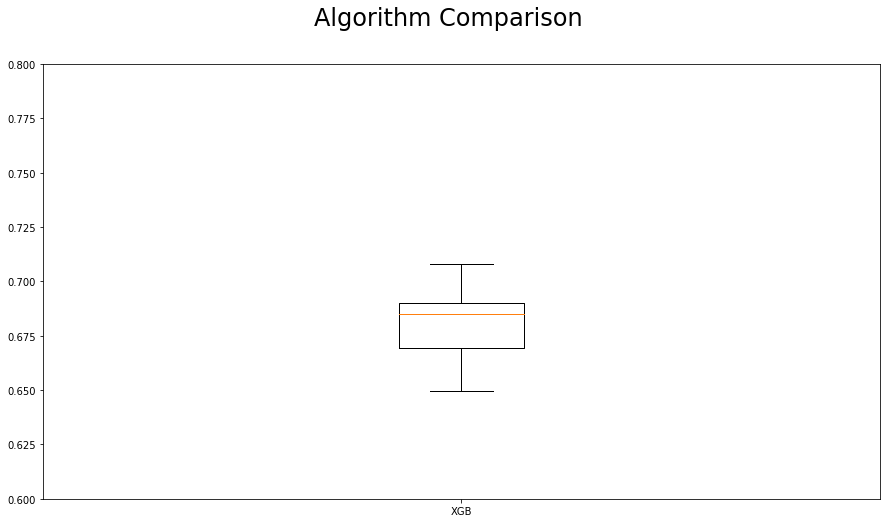

In [127]:
from xgboost import XGBClassifier


xgb = XGBClassifier(n_jobs=-1)

models = []
models.append(('XGB', xgb))




from sklearn.model_selection import cross_val_score

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, bin_X_train, bin_y_train, cv=kfold, scoring='f1', n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison', fontsize=24)
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
plt.ylim([0.60,0.80])
ax.set_xticklabels(names)
plt.show()

In [128]:
# Test Performance

bin_test_model = XGBClassifier(n_jobs=-1)
bin_test_model.fit(bin_X_train, bin_y_train)
bin_y_pred = bin_test_model.predict(X_test)
# F1
print("F1 score on binary unseen data: %.3f" % f1_score(bin_y_test, bin_y_pred))

F1 score on binary unseen data: 0.694


In [129]:
v_train_feat = []
v_train_label = []
for i in range(0,len(train_label)-1):
    if (bin_train_label[i] == 1):
        v_train_feat.append(train_feat.values[i])
        v_train_label.append(train_label[i])

v_train_feat = np.asarray(v_train_feat)
v_train_label = np.asarray(v_train_label)

In [130]:
num_val_samples = 0
num_test_samples = 420
v_X_train, v_X_test, v_X_val, v_y_train, v_y_test, v_y_val = train_test_validation_split(v_train_feat, v_train_label, num_val_samples, num_test_samples)

XGB: 0.416 (0.030)


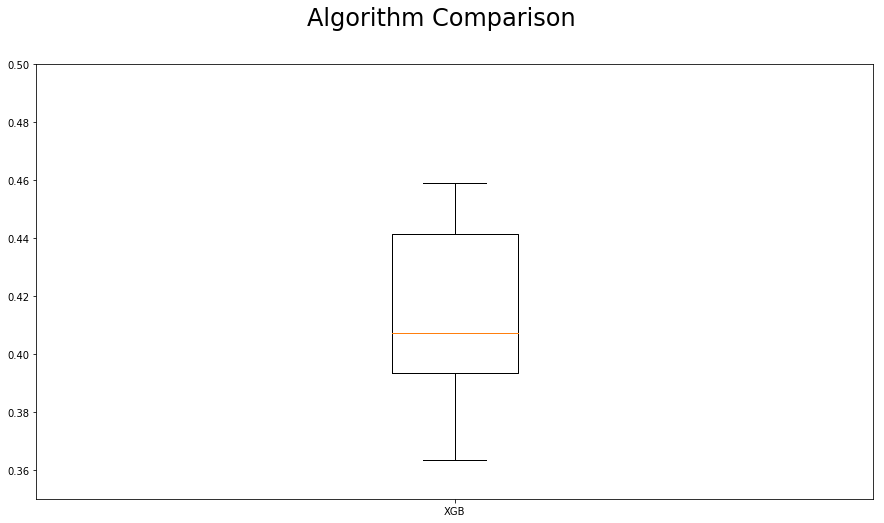

In [131]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, v_X_train, v_y_train, cv=kfold, scoring='f1_micro', n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison', fontsize=24)
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
plt.ylim([0.35,0.50])
ax.set_xticklabels(names)
plt.show()

In [132]:
# Test Performance

v_test_model = XGBClassifier(n_jobs=-1)
v_test_model.fit(v_X_train, v_y_train)
v_y_pred = v_test_model.predict(v_X_test)
# F1
print("F1 score on binary unseen data: %.3f" % f1_score(v_y_test, v_y_pred, average='micro'))

F1 score on binary unseen data: 0.405


In [134]:
bin_X_pred = test_data[train_data.columns[chi2_test.get_support(indices=True)]]

In [178]:
train_feat.shape, bin_train_label.shape, bin_X_pred.shape

((9567, 29), (9567,), (3190, 29))

In [161]:
bin_classifier = XGBClassifier(n_jobs=-1)
bin_classifier.fit(train_feat, bin_train_label)
bin_y_pred = bin_classifier.predict(bin_X_pred)

In [162]:
submit = test_data['ID']
submit = pd.DataFrame({'ID': submit})

pred = bin_y_pred
pred = pd.DataFrame({'Product': y_pred})

product = []
product = pred.Product
product

0       0
1       1
2       1
3       1
4       1
5       1
6       0
7       1
8       1
9       1
10      1
11      1
12      1
13      0
14      0
15      0
16      1
17      0
18      1
19      0
20      1
21      1
22      1
23      1
24      0
25      0
26      0
27      1
28      1
29      1
       ..
3160    1
3161    0
3162    0
3163    0
3164    1
3165    1
3166    0
3167    0
3168    0
3169    0
3170    0
3171    0
3172    0
3173    0
3174    0
3175    1
3176    0
3177    1
3178    0
3179    1
3180    0
3181    0
3182    0
3183    1
3184    0
3185    0
3186    0
3187    1
3188    1
3189    0
Name: Product, Length: 3190, dtype: int32

In [ ]:
# second prediction

In [176]:
v_X_pred = bin_X_pred
for i in range(0,len(product)):
    if(pred.values[i] == 0):
        v_X_pred = v_X_pred.drop(i)

In [173]:
v_train_feat.shape, v_train_label.shape, v_X_pred.shape

((4189, 29), (4189,), (1239, 29))

In [182]:
v_classifier = XGBClassifier(n_jobs=-1)
v_classifier.fit(v_train_feat, v_train_label)
v_y_pred = v_classifier.predict(v_X_pred)

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28'] ['DeviceFlag4G', 'DataArpu', 'DataAllowanceContinuous', 'DeviceFlagSmartphone', 'MonthlyVoiceTrafficCount', 'MonthlyDataTraffic', 'CustomerGender', 'CustomerExpatriate', 'ChurnScore', 'AirportConnectionsDuration', 'AirportConnectionsCount', 'StationConnectionsDuration', 'StationConnectionsCount', 'ParkingConnectionsDuration', 'ParkingConnectionsCount', 'File-Transfer', 'Instant-Messaging-Applications', 'Mail', 'Music-Streaming', 'P2P-Applications', 'Security', 'Streaming-Applications', 'Terminals', 'Unclassified', 'Web-Applications', 'IsModified', 'CustomerAge', 'Region', 'Province']
expected f17, f4, f3, f23, f26, f12, f10, f27, f11, f25, f24, f9, f5, f28, f0, f18, f7, f21, f8, f15, f13, f6, f20, f19, f1, f14, f22, f2, f16 in input data
training data did not have the following fields: ChurnScore, AirportConnectionsCount, P2P-Applications, CustomerAge, Unclassified, Province, ParkingConnectionsCount, Security, MonthlyDataTraffic, MonthlyVoiceTrafficCount, Instant-Messaging-Applications, Region, DeviceFlag4G, Mail, StationConnectionsCount, Music-Streaming, StationConnectionsDuration, IsModified, DataArpu, DataAllowanceContinuous, AirportConnectionsDuration, Terminals, ParkingConnectionsDuration, Web-Applications, CustomerExpatriate, DeviceFlagSmartphone, Streaming-Applications, CustomerGender, File-Transfer

In [179]:
v_pred = v_y_pred
v_pred = pd.DataFrame({'Product': v_pred})

v_product = []
v_product = v_pred.Product
v_product

0       1
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      1
13      1
14      1
15      1
16      1
17      1
18      1
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      1
27      1
28      1
29      1
       ..
1209    1
1210    1
1211    1
1212    1
1213    1
1214    1
1215    1
1216    1
1217    1
1218    1
1219    1
1220    1
1221    1
1222    1
1223    1
1224    1
1225    1
1226    1
1227    1
1228    1
1229    1
1230    1
1231    1
1232    1
1233    1
1234    1
1235    1
1236    1
1237    1
1238    1
Name: Product, Length: 1239, dtype: int32